In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from dviforbml.utils.helper import download_run_np
from collections import defaultdict
import os

In [11]:
project = "DVINP-HOPE-NEW"

num_steps = [16, 64]
self_attn_num_heads = [None, 8]
max_context_size = [None, 16]
context_variant = ["mean", "bca"]
model_variant = ["dis", "dis_score"]
noise_variant = ["free"]
contextual_schedules = [True]
trainer_variant = ["cntxt", "fwdcntxt"]
seed = [11, 23]

group_ids = [
    "Number of Diffusion Steps",
    "With Self-Attention",
    "With Context Size Embedding",
    "Context Variant",
    "DVI Variant",
    "Noise Schedule Variant",
    "With Contextual Schedules",
    "Objective",
    "Seed",
]

names = [
    "-".join(map(str, values))
    for values in product(
        num_steps,
        self_attn_num_heads,
        max_context_size,
        context_variant,
        model_variant,
        noise_variant,
        contextual_schedules,
        trainer_variant,
        seed,
    )
]

# names.remove("16-None-10-bca-constr-cmcd-True")
# names.remove("16-4-None-bca-constr-ula-True")
print(names)

['16-None-None-mean-dis-free-True-cntxt-11', '16-None-None-mean-dis-free-True-cntxt-23', '16-None-None-mean-dis-free-True-fwdcntxt-11', '16-None-None-mean-dis-free-True-fwdcntxt-23', '16-None-None-mean-dis_score-free-True-cntxt-11', '16-None-None-mean-dis_score-free-True-cntxt-23', '16-None-None-mean-dis_score-free-True-fwdcntxt-11', '16-None-None-mean-dis_score-free-True-fwdcntxt-23', '16-None-None-bca-dis-free-True-cntxt-11', '16-None-None-bca-dis-free-True-cntxt-23', '16-None-None-bca-dis-free-True-fwdcntxt-11', '16-None-None-bca-dis-free-True-fwdcntxt-23', '16-None-None-bca-dis_score-free-True-cntxt-11', '16-None-None-bca-dis_score-free-True-cntxt-23', '16-None-None-bca-dis_score-free-True-fwdcntxt-11', '16-None-None-bca-dis_score-free-True-fwdcntxt-23', '16-None-16-mean-dis-free-True-cntxt-11', '16-None-16-mean-dis-free-True-cntxt-23', '16-None-16-mean-dis-free-True-fwdcntxt-11', '16-None-16-mean-dis-free-True-fwdcntxt-23', '16-None-16-mean-dis_score-free-True-cntxt-11', '16-None-

In [12]:
# from tqdm import tqdm

# for name in tqdm(names):
#     download_run_np(project, name)

In [13]:
def group_names_by_index(names, index):
    grouped = defaultdict(list)
    for name in names:
        parts = name.split("-")
        if index < len(parts):
            key = parts[index]
            grouped[key].append(name)
    return dict(grouped)

In [20]:
def group_names_custom(names, cv):
    grouped = defaultdict(list)

    for name in names:
        parts = name.split("-")

        num_steps = parts[0]
        self_attn = parts[1]
        context_size = parts[2]
        context_variant = parts[3]
        model_variant = parts[4]
        noise_variant = parts[5]
        contextual_schedules = parts[6]
        trainer_variant = parts[7]
        seed = parts[8]

        # Group 1
        if context_variant == cv and model_variant == "dis":
            if self_attn == "None":
                if context_size == "None":
                    grouped["no_context_size_no_attn"].append(name)
                else:
                    grouped["with_context_size_no_attn"].append(name)
            else:
                if context_size == "None":
                    grouped["no_context_size_with_attn"].append(name)
                else:
                    grouped["with_context_size_with_attn"].append(name)

    return dict(grouped)

In [15]:
def group_names_custom2(names, dviv):
    grouped = defaultdict(list)

    for name in names:
        parts = name.split("-")

        num_steps = parts[0]
        self_attn = parts[1]
        context_size = parts[2]
        context_variant = parts[3]
        model_variant = parts[4]
        noise_variant = parts[5]
        contextual_schedules = parts[6]
        trainer_variant = parts[7]
        seed = parts[8]

        # Group 1
        if model_variant == dviv:
            if noise_variant == "free":
                if contextual_schedules == "True":
                    grouped["schedules_free_and_contextual"].append(name)
                elif contextual_schedules == "False":
                    grouped["schedules_free_and_not_contextual"].append(name)
            elif noise_variant == "constr":
                if contextual_schedules == "True":
                    grouped["schedules_constr_and_contextual"].append(name)
                elif contextual_schedules == "False":
                    grouped["schedules_constr_and_not_contextual"].append(name)

    return dict(grouped)

In [16]:
def average_group_data(grouped_names):
    averaged_data = {}

    for group_value, name_list in grouped_names.items():
        data_frames = []

        for name in name_list:
            file_path = f"../models/{project}/{name}/metrics.csv"
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df = df.rename(columns={df.columns[0]: "index"})
                data_frames.append(df)
            else:
                print(f"Missing file: {file_path}")

        if data_frames:
            # Merge and average by 'index'
            all_df = pd.concat(data_frames)
            avg_df = all_df.groupby("index").median().reset_index()
            averaged_data[group_value] = avg_df

    return averaged_data


def max_group_data(grouped_names):
    averaged_data = {}

    for group_value, name_list in grouped_names.items():
        data_frames = []

        for name in name_list:
            file_path = f"../models/{project}/{name}/metrics.csv"
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df = df.rename(columns={df.columns[0]: "index"})
                data_frames.append(df)
            else:
                print(f"Missing file: {file_path}")

        if data_frames:
            # Merge and average by 'index'
            all_df = pd.concat(data_frames)
            avg_df = all_df.groupby("index").max().reset_index()
            averaged_data[group_value] = avg_df

    return averaged_data


def plot_group_averages(averaged_data, i, value_column):
    plt.figure(figsize=(4, 2))
    for group_name, df in averaged_data.items():
        plt.plot(df["index"], df[value_column], label=group_name, marker="o")

    plt.xlabel("Context Size")
    plt.ylabel("Average JSD")
    plt.title(f"{group_ids[i]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"{group_ids[i]}.pdf")
    plt.show()

dict_keys(['schedules_free_and_contextual'])
Missing file: ../models/DVINP-HOPE-NEW/64-None-None-bca-dis-free-True-fwdcntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/64-None-16-bca-dis-free-True-fwdcntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/64-8-None-mean-dis-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/64-8-None-mean-dis-free-True-fwdcntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/64-8-16-mean-dis-free-True-fwdcntxt-11/metrics.csv
dict_keys(['schedules_free_and_contextual'])
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-mean-dis_score-free-True-fwdcntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-bca-dis_score-free-True-fwdcntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-mean-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-bca-dis_s

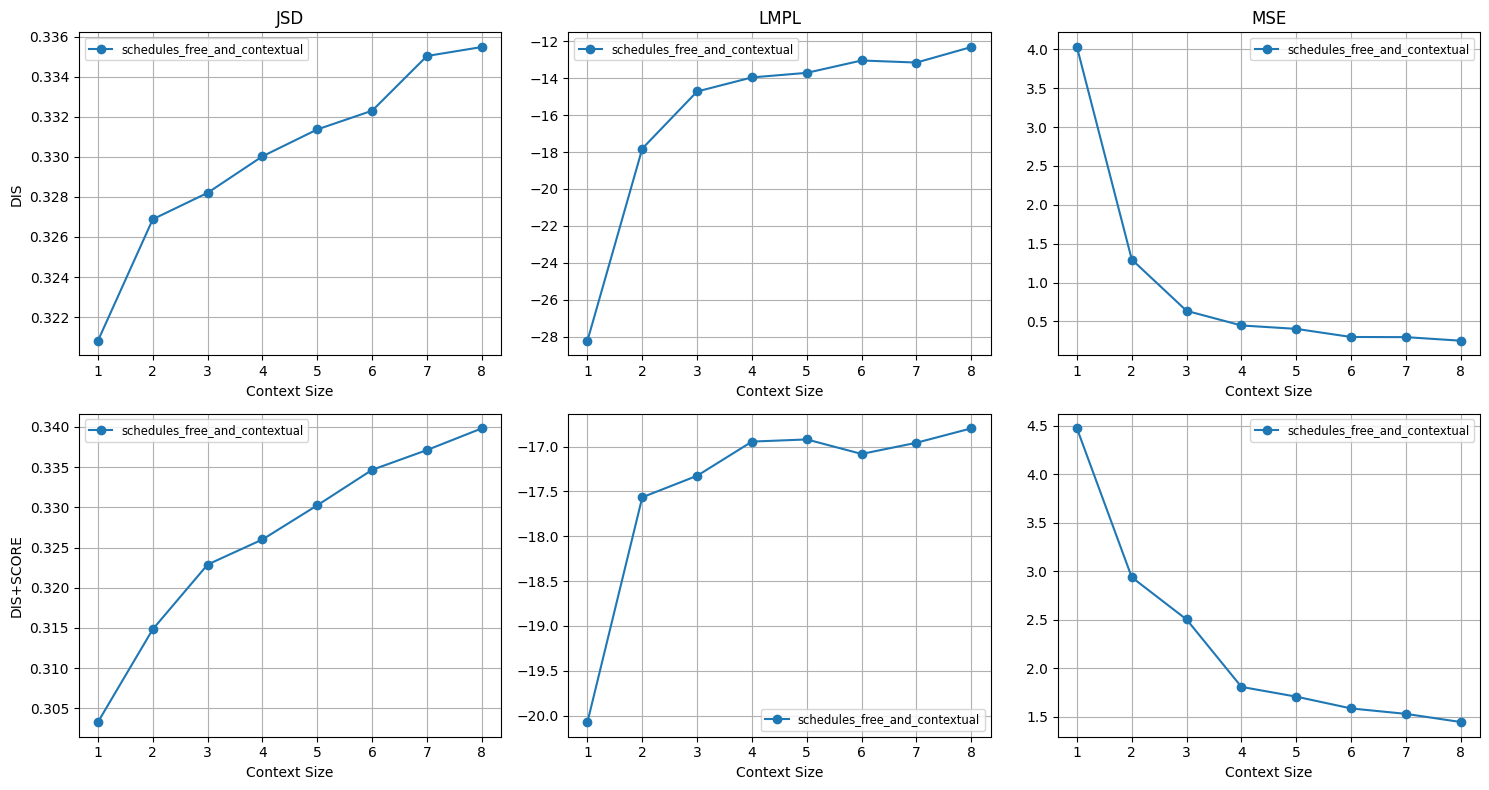

In [17]:
fig, axes = plt.subplots(
    2, 3, figsize=(15, 8)
)  # 2 rows (dis/dis_score), 3 columns (metrics)
cvs = ["dis", "dis_score"]
metrics = ["jsd", "lmpl", "mse"]

for row_idx, cv in enumerate(cvs):
    grouped = group_names_custom2(names, cv)
    print(grouped.keys())
    max_data = average_group_data(grouped)

    for col_idx, metric in enumerate(metrics):
        ax = axes[row_idx, col_idx]
        for group_name, df in max_data.items():
            label = group_name
            ax.plot(df["index"], df[metric], label=label, marker="o")

        if row_idx == 0:
            ax.set_title(metric.upper())
        if col_idx == 0:
            ax.set_ylabel("DIS" if cv == "dis" else "DIS+SCORE")

        ax.set_xlabel("Context Size")
        ax.grid(True)
        ax.legend(fontsize="small")

plt.tight_layout()
plt.savefig("ahh.pdf")
plt.show()

dict_keys(['no_context_size_no_attn', 'with_context_size_no_attn', 'no_context_size_with_attn', 'with_context_size_with_attn'])
Missing file: ../models/DVINP-HOPE-NEW/64-8-None-mean-dis-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/64-8-None-mean-dis-free-True-fwdcntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/64-8-16-mean-dis-free-True-fwdcntxt-11/metrics.csv
dict_keys(['no_context_size_no_attn', 'with_context_size_no_attn', 'no_context_size_with_attn', 'with_context_size_with_attn'])
Missing file: ../models/DVINP-HOPE-NEW/64-None-None-bca-dis-free-True-fwdcntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/64-None-16-bca-dis-free-True-fwdcntxt-23/metrics.csv


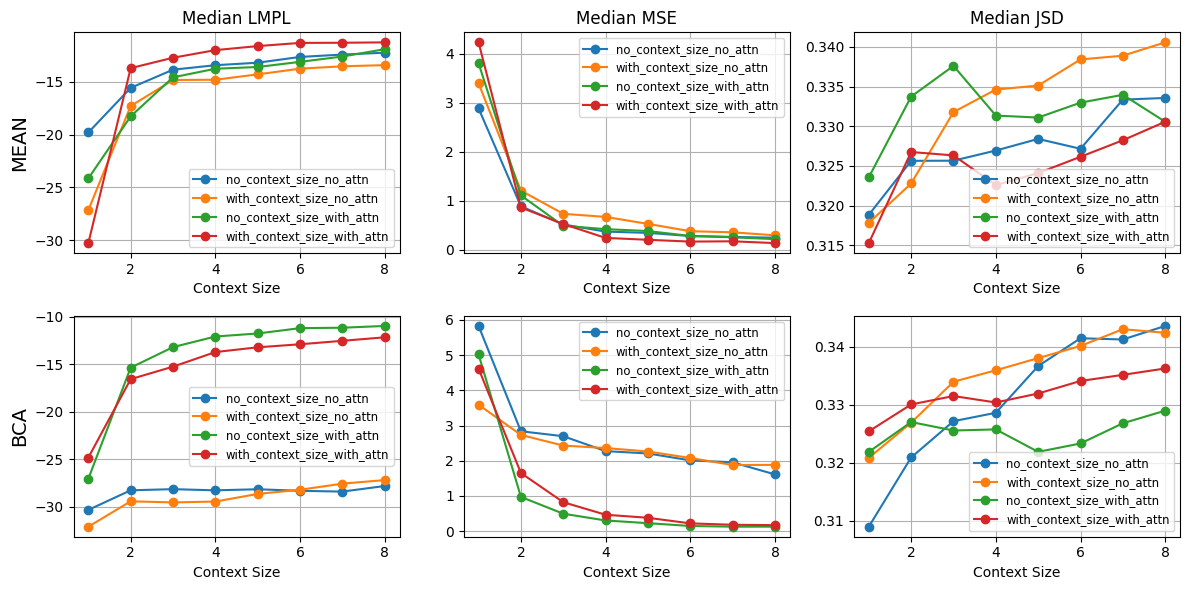

In [23]:
fig, axes = plt.subplots(
    2, 3, figsize=(12, 6)
)  # 2 rows (mean/bca), 3 columns (metrics)
cvs = ["mean", "bca"]
metrics = ["lmpl", "mse", "jsd"]

for row_idx, cv in enumerate(cvs):
    grouped = group_names_custom(names, cv)
    print(grouped.keys())
    max_data = average_group_data(grouped)

    for col_idx, metric in enumerate(metrics):
        ax = axes[row_idx, col_idx]
        for group_name, df in max_data.items():
            label = group_name
            ax.plot(df["index"], df[metric], label=label, marker="o")

        if row_idx == 0:
            ax.set_title(f"Median {metric.upper()}")
        if col_idx == 0:
            ax.set_ylabel(cv.upper(), fontsize=14)

        ax.set_xlabel("Context Size")
        ax.grid(True)
        ax.legend(fontsize="small")

# plt.suptitle("Contextualization Comparisons", fontsize=14)
plt.tight_layout()
plt.savefig("contextualization.pdf")
plt.show()

dict_keys(['16', '64'])
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-mean-dis_score-free-True-fwdcntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-bca-dis_score-free-True-fwdcntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-mean-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-bca-dis_score-free-True-cntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-cntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-fwdcntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing fi

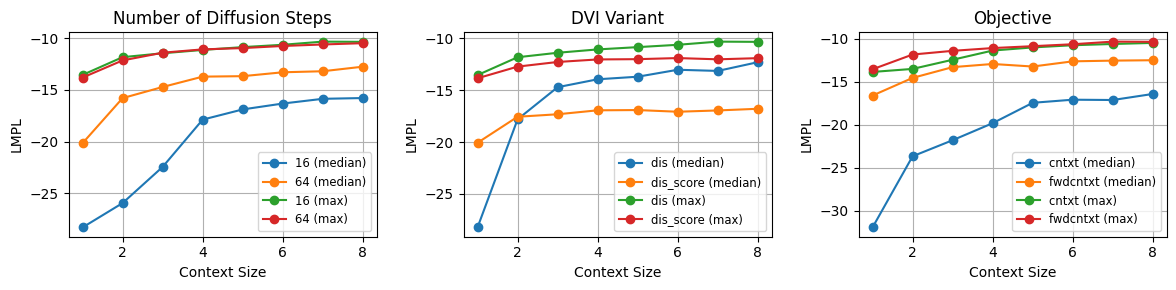

In [22]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(12, 3),
)  # 6 plots total (since we're skipping one)
axes = axes.flatten()

metric = "lmpl"

plot_indices = [i for i in range(9) if i not in [1, 2, 3, 5, 6, 8]]  # exclude index 5

for ax, i in zip(axes, plot_indices):
    grouped = group_names_by_index(names, i)
    print(grouped.keys())
    max_data = max_group_data(grouped)
    average_data = average_group_data(grouped)

    for group_name, df in average_data.items():
        if i == 1:
            if group_name == "8":
                label = "True"
            else:
                label = "False"
        elif i == 2:
            if group_name == "16":
                label = "True"
            else:
                label = "False"
        else:
            label = group_name

        label = f"{label} (median)"

        ax.plot(df["index"], df[metric], label=label, marker="o")

    for group_name, df in max_data.items():
        if i == 1:
            if group_name == "8":
                label = "True"
            else:
                label = "False"
        elif i == 2:
            if group_name == "16":
                label = "True"
            else:
                label = "False"
        else:
            label = group_name

        label = f"{label} (max)"

        ax.plot(df["index"], df[metric], label=label, marker="o")

    ax.set_title(group_ids[i])
    ax.set_xlabel("Context Size")
    ax.set_ylabel(f"{metric.upper()}")
    ax.grid(True)
    ax.legend(fontsize="small")

# plt.suptitle("Configuration Comparisons", fontsize=14)
plt.tight_layout()
plt.savefig("median_max.pdf")
plt.show()

dict_keys(['16', '64'])
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-mean-dis_score-free-True-fwdcntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-bca-dis_score-free-True-fwdcntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-mean-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-bca-dis_score-free-True-cntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-cntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-fwdcntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing fi

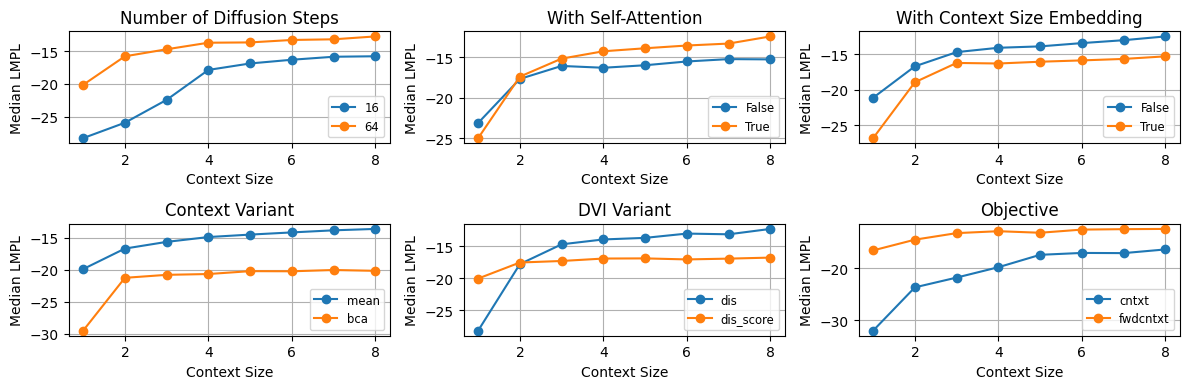

In [ ]:
fig, axes = plt.subplots(
    2, 3, figsize=(12, 4)
)  # 6 plots total (since we're skipping one)
axes = axes.flatten()

metric = "lmpl"

plot_indices = [i for i in range(9) if i not in [5, 6, 8]]  # exclude index 5

for ax, i in zip(axes, plot_indices):
    grouped = group_names_by_index(names, i)
    print(grouped.keys())
    average_data = average_group_data(grouped)

    for group_name, df in average_data.items():
        if i == 1:
            if group_name == "8":
                label = "True"
            else:
                label = "False"
        elif i == 2:
            if group_name == "16":
                label = "True"
            else:
                label = "False"
        else:
            label = group_name

        ax.plot(df["index"], df[metric], label=label, marker="o")

    ax.set_title(group_ids[i])
    ax.set_xlabel("Context Size")
    ax.set_ylabel(f"Average {metric.upper()}")
    ax.grid(True)
    ax.legend(fontsize="small")

plt.tight_layout()
plt.savefig("median.pdf")
plt.show()

In [ ]:
# for i in range(7):
#     grouped = group_names_by_index(names, i)
#     average_data = average_group_data(grouped)
#     plot_group_averages(average_data, i)

In [26]:
def get_avg_metric_per_name(names, metric):
    avg_metric_map = {}

    for name in names:
        file_path = f"../models/{project}/{name}/metrics.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df = df.rename(columns={df.columns[0]: "index"})
            avg_metric = df[metric].mean()
            avg_metric_map[name] = avg_metric
        else:
            print(f"Missing file: {file_path}")

    return avg_metric_map


def plot_top_lmpl_and_mse(names, top_n=4):
    metrics = [("lmpl", True), ("mse", False)]  # (metric, reverse sort)

    fig, axes = plt.subplots(1, 2, figsize=(12, 3))

    for ax, (metric, reverse) in zip(axes, metrics):
        avg_metric_map = get_avg_metric_per_name(names, metric=metric)
        top_names = sorted(avg_metric_map, key=avg_metric_map.get, reverse=reverse)[
            :top_n
        ]

        for name in top_names:
            file_path = f"../models/{project}/{name}/metrics.csv"
            df = pd.read_csv(file_path)
            df = df.rename(columns={df.columns[0]: "index"})
            ax.plot(
                df["index"],
                df[metric],
                marker="o",
                label=f"{name} (avg={avg_metric_map[name]:.3f})",
            )

        ax.set_xlabel("Context Size")
        ax.set_ylabel(metric.upper())
        ax.legend(fontsize="small")
        ax.grid(True)

    # plt.suptitle("Top 4 (By Average over Context Sizes)", fontsize=14)
    plt.tight_layout()
    plt.savefig("top_lmpl_mse.pdf")
    plt.show()

Missing file: ../models/DVINP-HOPE-NEW/16-None-None-mean-dis_score-free-True-fwdcntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-bca-dis_score-free-True-fwdcntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-mean-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-bca-dis_score-free-True-cntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-cntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-fwdcntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE

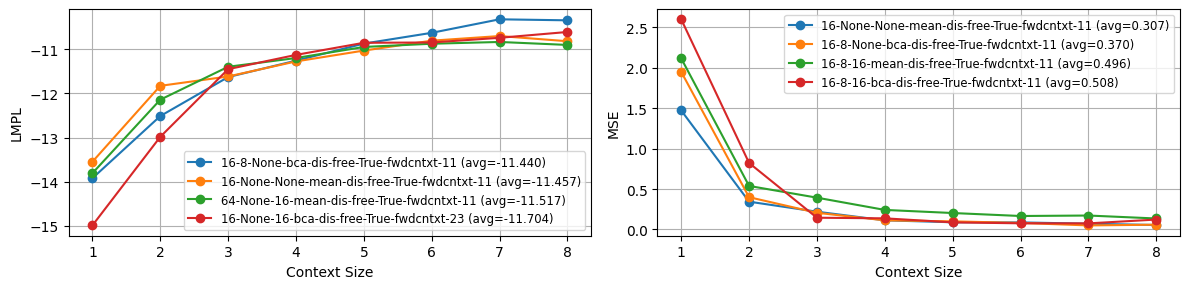

In [27]:
plot_top_lmpl_and_mse(names)

In [25]:
def get_avg_metric_per_name(names, metric):
    avg_metric_map = {}

    for name in names:
        file_path = f"../models/{project}/{name}/metrics.csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df = df.rename(columns={df.columns[0]: "index"})
            avg_metric = df[metric].mean()
            avg_metric_map[name] = avg_metric
        else:
            print(f"Missing file: {file_path}")

    return avg_metric_map


def plot_top_n_metric(names, top_n=4, metric="mse", reverse=False):
    avg_metric_map = get_avg_metric_per_name(names, metric=metric)

    # Sort names by average jsd
    top_names = sorted(avg_metric_map, key=avg_metric_map.get, reverse=reverse)[:top_n]

    plt.figure(figsize=(6, 4))
    for name in top_names:
        file_path = f"../models/{project}/{name}/metrics.csv"
        df = pd.read_csv(file_path)
        df = df.rename(columns={df.columns[0]: "index"})
        plt.plot(
            df["index"],
            df[metric],
            marker="o",
            label=f"{name} (avg={avg_metric_map[name]:.3f})",
        )

    plt.xlabel("Context Size Index")
    plt.ylabel(metric.upper())
    plt.title(f"Top {top_n} Models with Best Average {metric.upper()}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("top3.pdf")
    plt.show()

Missing file: ../models/DVINP-HOPE-NEW/16-None-None-mean-dis_score-free-True-fwdcntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-None-bca-dis_score-free-True-fwdcntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-mean-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-None-16-bca-dis_score-free-True-cntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-cntxt-23/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-mean-dis_score-free-True-fwdcntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE-NEW/16-8-None-bca-dis_score-free-True-cntxt-11/metrics.csv
Missing file: ../models/DVINP-HOPE

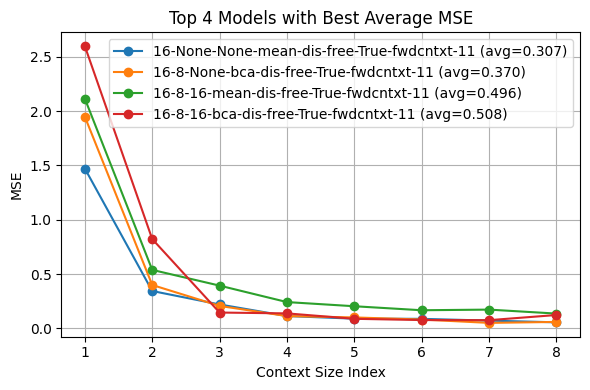

In [26]:
plot_top_n_metric(names)

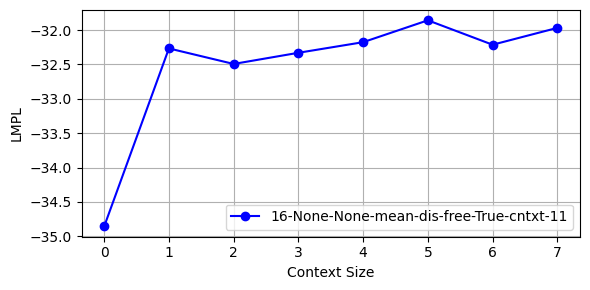

In [45]:
name = names[0]

figure = plt.figure(figsize=(6, 3))

df = pd.read_csv(f"../models/{project}/{name}/metrics.csv")
df.head

plt.plot(df.index, df["lmpl"], marker="o", label=name, color="blue")

plt.xlabel("Context Size")
plt.ylabel("LMPL")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()